In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')

import os
import tensorflow as tf
import keras
import cv2

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.applications.vgg19 import VGG19
from keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPool2D,BatchNormalization, LSTM,MaxPooling2D
from keras.models import Sequential
from keras import regularizers
import keras

from keras.layers import TimeDistributed
from keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2

from tensorflow.keras.optimizers import Adam

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
train_dir = '/kaggle/input/fer2013/train/'
test_dir = '/kaggle/input/fer2013/test/'

In [3]:
def Classes_Count( path, name):
    Classes_Dict = {}
    
    for Class in os.listdir(path):
        
        Full_Path = path + Class
        Classes_Dict[Class] = len(os.listdir(Full_Path))
        
    df = pd.DataFrame(Classes_Dict, index=[name])
    
    return df

Train_Count = Classes_Count(train_dir, 'Train').transpose().sort_values(by="Train", ascending=False)
Test_Count = Classes_Count(test_dir, 'Test').transpose().sort_values(by="Test", ascending=False)

In [4]:
pd.concat([Train_Count,Test_Count] , axis=1)

,Train,Test
happy,7215,1774
neutral,4965,1233
sad,4830,1247
fear,4097,1024
angry,3995,958
surprise,3171,831
disgust,436,111


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0, 0.5, 'Training image Count')

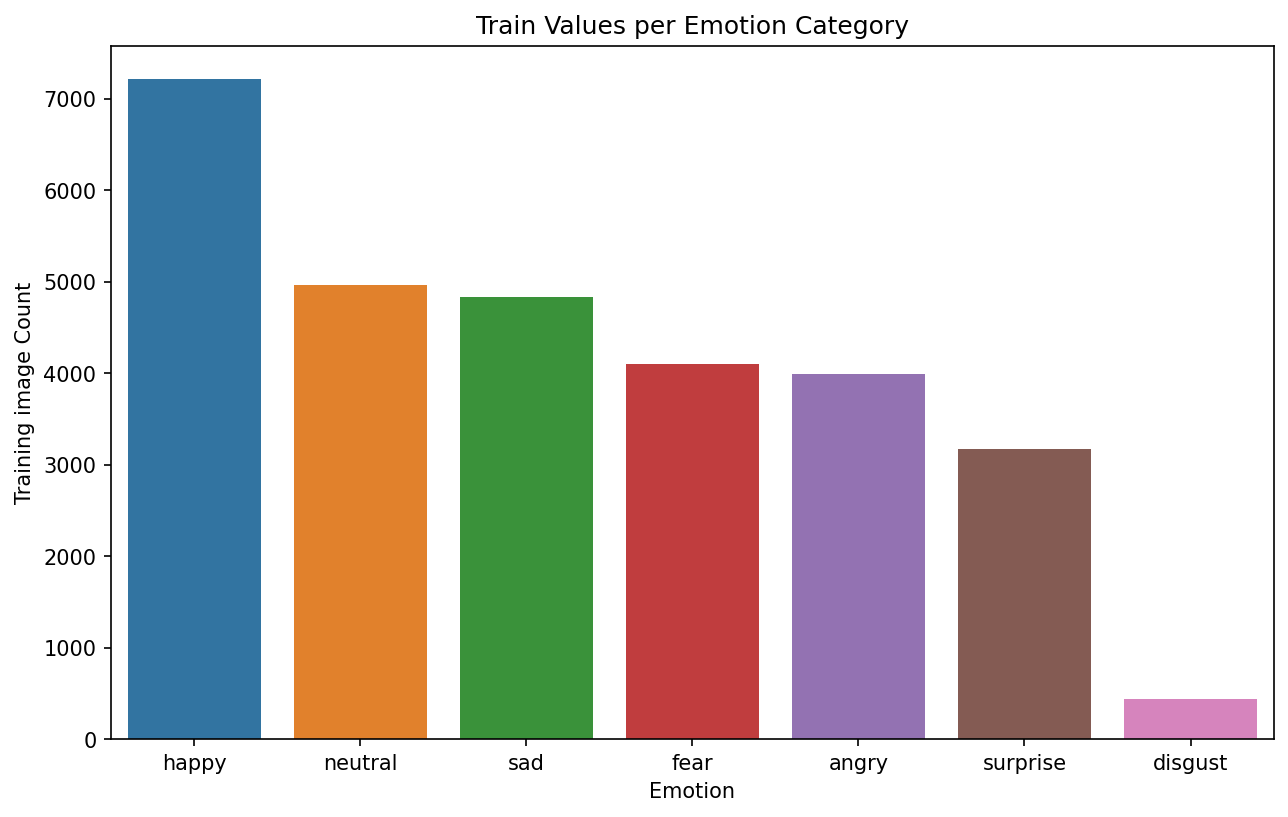

In [5]:
plt.figure(figsize=(10, 6),dpi=150)
sns.barplot(x=Train_Count.index, y='Train', data=Train_Count)
plt.title('Train Values per Emotion Category')
plt.xlabel('Emotion')
plt.ylabel('Training image Count')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0, 0.5, 'Testing image Count')

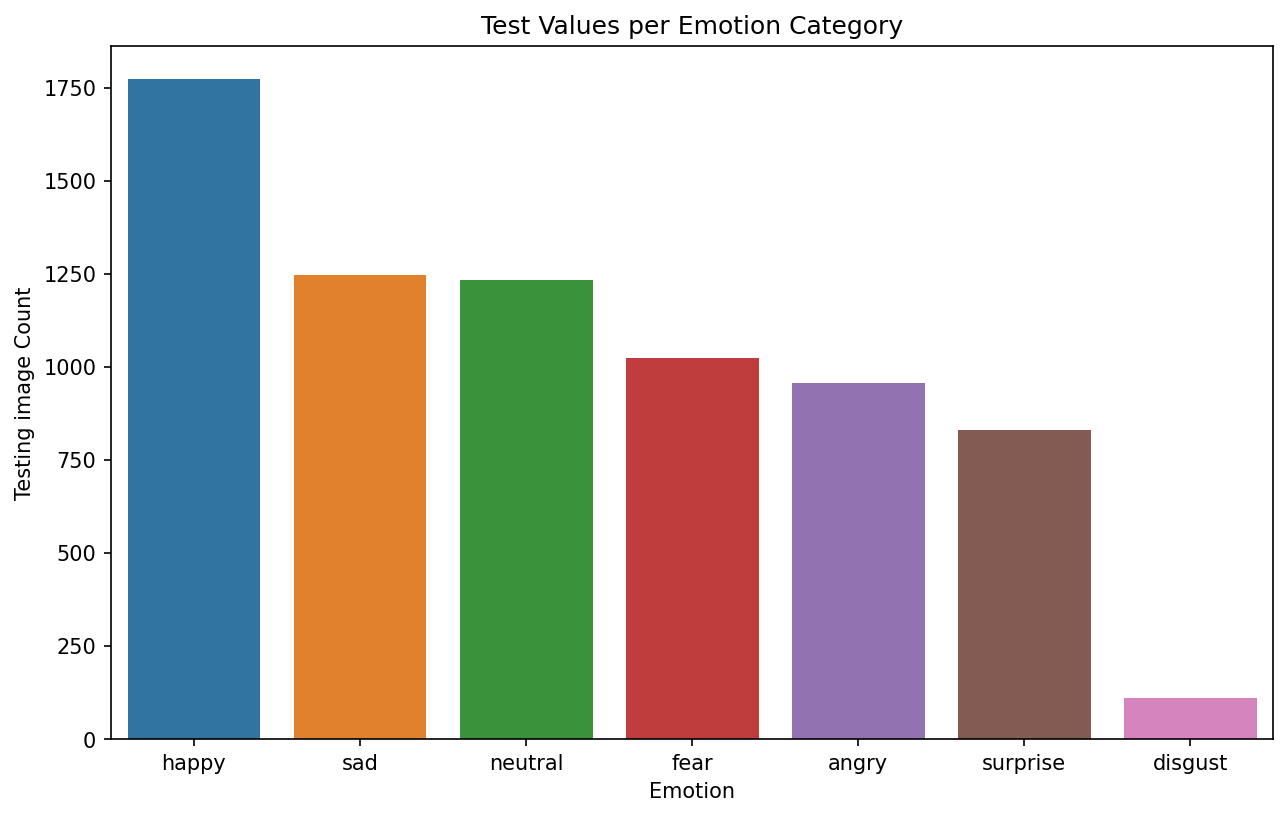

In [6]:
plt.figure(figsize=(10, 6),dpi=150)
sns.barplot(x=Test_Count.index, y='Test', data=Test_Count)
plt.title('Test Values per Emotion Category')
plt.xlabel('Emotion')
plt.ylabel('Testing image Count')

Image Shape: (48, 48, 3)
Image Shape: (48, 48, 3)
Image Shape: (48, 48, 3)
Image Shape: (48, 48, 3)
Image Shape: (48, 48, 3)
Image Shape: (48, 48, 3)
Image Shape: (48, 48, 3)


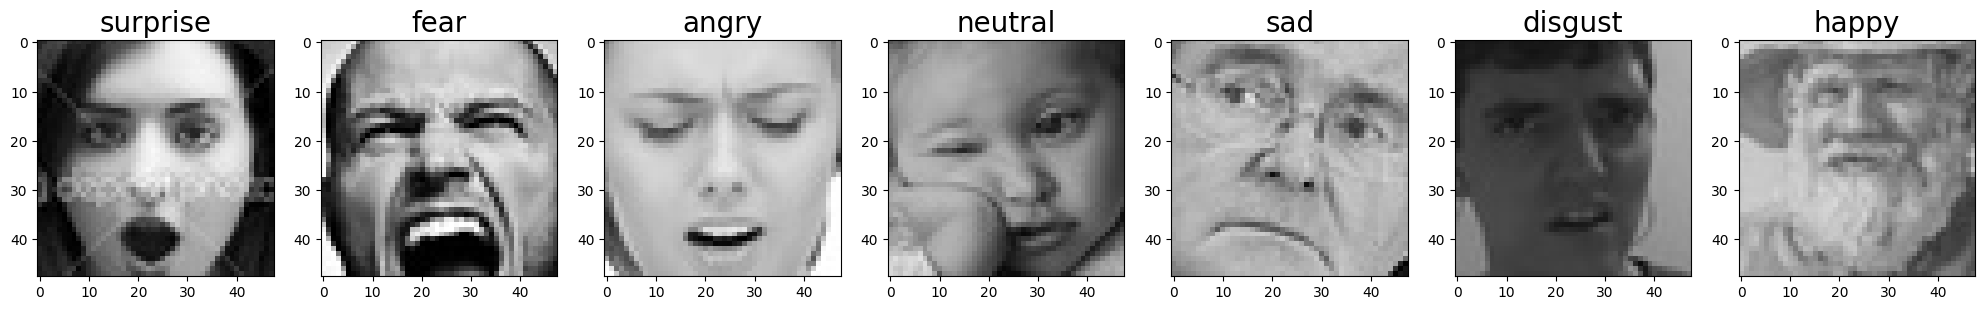

In [7]:
plt.style.use('default')
plt.figure(figsize = (25, 8))
image_count = 1
BASE_URL = '/kaggle/input/fer2013/train/'

for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(1, 7, image_count)
                image_count += 1
                image = cv2.imread(BASE_URL + directory + '/' + file)
                image_shape = image.shape
                print("Image Shape:", image_shape)
                plt.imshow(image)
                plt.title(directory, fontsize = 20)

In [8]:
img_shape = 48
batch_size = 128
train_data_path = '/kaggle/input/fer2013/train'
test_data_path = '/kaggle/input/fer2013/test'

In [9]:
train_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
        # Data Augmentation
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,                                        
        fill_mode='nearest',
    )


test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

In [10]:
train_data = train_preprocessor.flow_from_directory(
    train_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='grayscale', 
    shuffle=True,
    batch_size=batch_size,
    subset='training', 
)


test_data = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='grayscale',
    shuffle=False,
    batch_size=batch_size,
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [11]:
def Create_CNN_Model():
    model = Sequential()

    # CNN1
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(img_shape, img_shape, 1)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(0.25))

    # CNN2
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(0.25))

    # CNN3
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(0.25))

    # Global Average Pooling
    model.add(GlobalAveragePooling2D())

    # Fully Connected Layers
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(7, activation='softmax'))

    return model


In [12]:
CNN_Model = Create_CNN_Model()

CNN_Model.summary()

CNN_Model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy']) #Lr=0.001

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 46, 46, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 batch_normalization_1 (Bat  (None, 46, 46, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 64)        0         
 D)                                                              
                                                        

In [13]:
# Callback Checkpoint
checkpoint_path = "CNN_Model_Checkpoint.h5"

Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True,mode='max',verbose=1)

# Early Stopping Callback to monitor the accuracy
Early_Stopping = EarlyStopping(monitor = 'val_accuracy', patience = 15, restore_best_weights = True, verbose=1)

# ReduceLROnPlateau Callback to reduce overfitting by decreasing learning rate
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=0.000005,
    verbose=1
)


callbacks = [Early_Stopping, Reducing_LR]

steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size

In [14]:
CNN_history = CNN_Model.fit( train_data , validation_data= test_data , epochs=50, batch_size= batch_size,
                            callbacks=callbacks, steps_per_epoch= steps_per_epoch, validation_steps=validation_steps)
# Save the entire model (architecture + weights)
CNN_Model.save("/kaggle/working/CNN_Final_Modelv2.h5")
CNN_Model.save_weights("/kaggle/working/CNN_Final_Model_Weightsv2.h5")

Epoch 1/50


2023-11-14 12:16:54.935966: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


224/224 [==============================] - 221s 923ms/step - loss: 2.2975 - accuracy: 0.1961 - val_loss: 1.9299 - val_accuracy: 0.2475 - lr: 0.0010
Epoch 2/50
224/224 [==============================] - 45s 201ms/step - loss: 1.9142 - accuracy: 0.2450 - val_loss: 1.8407 - val_accuracy: 0.2123 - lr: 0.0010
Epoch 3/50
224/224 [==============================] - 44s 198ms/step - loss: 1.6940 - accuracy: 0.3347 - val_loss: 2.2332 - val_accuracy: 0.3069 - lr: 0.0010
Epoch 4/50
224/224 [==============================] - 44s 198ms/step - loss: 1.4931 - accuracy: 0.4219 - val_loss: 1.3955 - val_accuracy: 0.4725 - lr: 0.0010
Epoch 5/50
224/224 [==============================] - 44s 197ms/step - loss: 1.3512 - accuracy: 0.4812 - val_loss: 1.4406 - val_accuracy: 0.4634 - lr: 0.0010
Epoch 6/50
224/224 [==============================] - ETA: 0s - loss: 1.2769 - accuracy: 0.5113
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
224/224 [==============================] - 44s 

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [15]:
hist=CNN_history.history

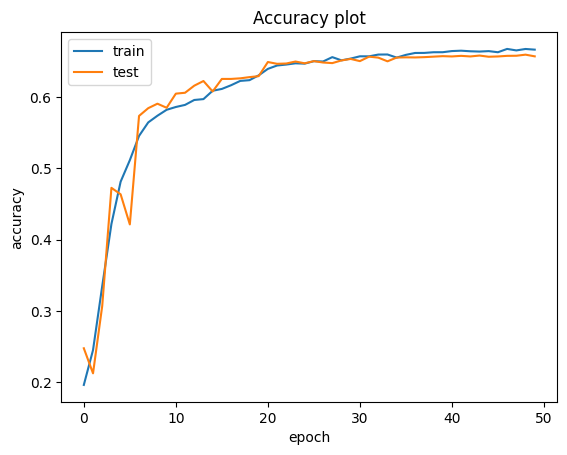

In [16]:
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.title("Accuracy plot")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.savefig("CNNv2_accuracy.png")

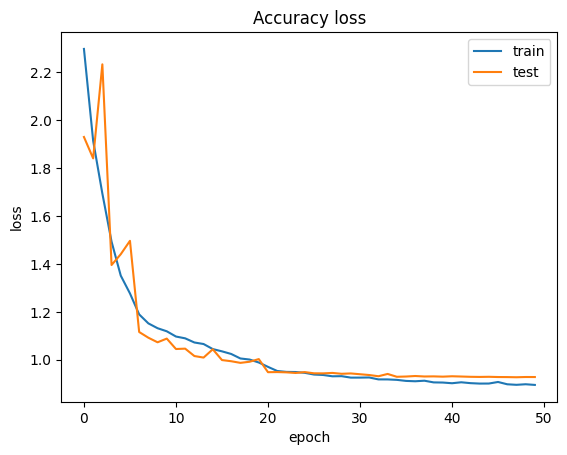

In [17]:

plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.title("Accuracy loss")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.savefig("CNNv2_loss.png")
     